In [1]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.morphology import closing, square
from PIL import Image
import matplotlib.pyplot as plt
from utils import thin_spiral_image_with_custom_cut, find_spiral_start, \
         trace_spiral_and_create_image

In [31]:
#path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\data\parkinson11.tiff'
path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\data\control3.tiff'
#path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\data\parkinson_dynamic7.tiff'

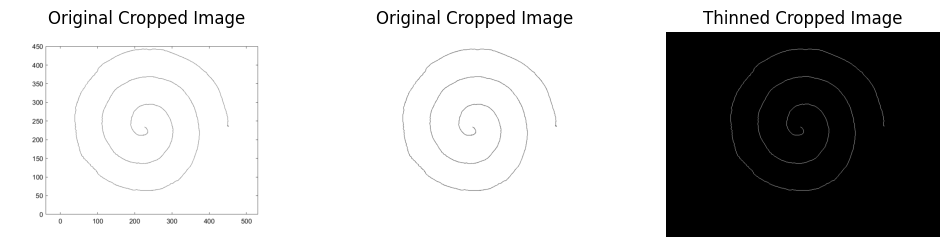

In [32]:

# Cut away 122 pixels and process the image
img, cut_img_cropped, skeleton_img_cropped = thin_spiral_image_with_custom_cut(path, white_out=True,  field_of_interest=[(-81, 57), (-91, 122)])

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Cropped Image')
axes[0].axis('off')

# Original image after cutting 122 pixels from the borders
axes[1].imshow(cut_img_cropped, cmap='gray')
axes[1].set_title('Original Cropped Image')
axes[1].axis('off')

# Thinned image
axes[2].imshow(skeleton_img_cropped, cmap='gray')
axes[2].set_title('Thinned Cropped Image')
axes[2].axis('off')

plt.show()


(429, 305)
<class 'tuple'>


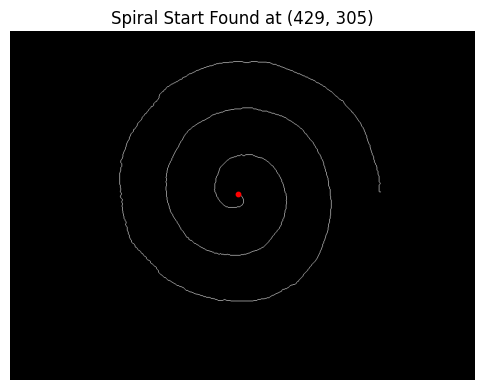

(429, 305)

In [33]:
# Find the start of the spiral with the refined method
spiral_start_refined = find_spiral_start(skeleton_img_cropped, point=(0, 0), first=True)
print(spiral_start_refined)
print(type(spiral_start_refined))
# Plotting the result with the refined start point marked
plt.figure(figsize=(6, 6))
plt.imshow(skeleton_img_cropped, cmap='gray')
if spiral_start_refined:
    plt.scatter(*spiral_start_refined, color='red', s=10)  # Mark the start with a red dot
    plt.title(f'Spiral Start Found at {spiral_start_refined}')
else:
    plt.title('Spiral Start Not Found')
plt.axis('off')
plt.show()

spiral_start_refined


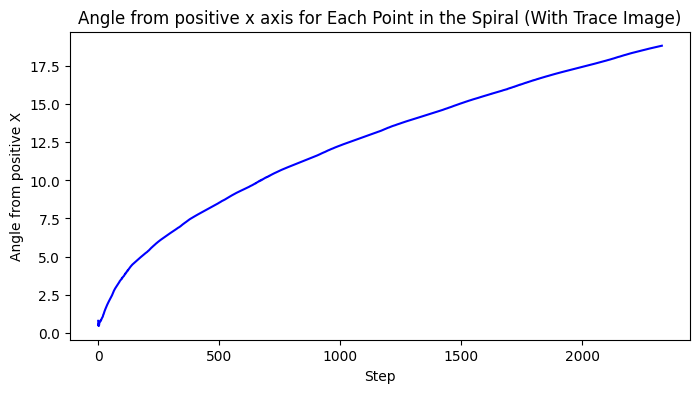

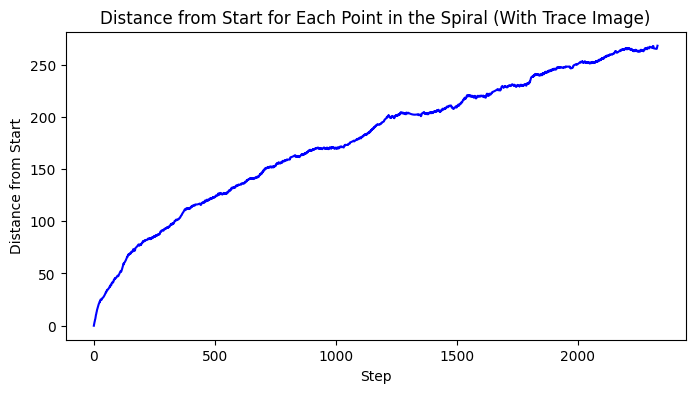

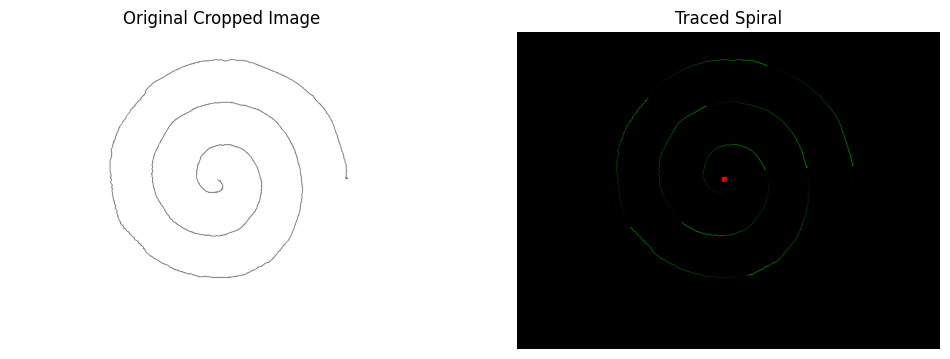

In [34]:
# Trace the spiral and create the image
skeleton_img_trace = skeleton_img_cropped.copy()
trace_path, trace_distances, trace_result_image, trace_angle = trace_spiral_and_create_image(skeleton_img_trace, spiral_start_refined)

# Convert the trace image to PIL image for saving and displaying
trace_result_pil_image = Image.fromarray(trace_result_image)
#trace_image_output_path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\data\control1_traced.tiff'
#trace_result_pil_image.save(trace_image_output_path)

x = np.linspace(0,2000,2000)

for i in range(len(trace_angle)-1):
    if trace_angle[i] - trace_angle[i+1] > 2:
        trace_angle[i+1:] += np.pi * np.ones(len(trace_angle[i+1:]))
    elif trace_angle[i] - trace_angle[i+1] < -2:
        trace_angle[i+1:] -= np.pi * np.ones(len(trace_angle[i+1:]))

# Plot the distances
plt.figure(figsize=(8, 4))
plt.plot(trace_angle, color='blue')
plt.title('Angle from positive x axis for Each Point in the Spiral (With Trace Image)')
plt.xlabel('Step')
plt.ylabel('Angle from positive X')
plt.show()

# Plot the distances
plt.figure(figsize=(8, 4))
plt.plot(trace_distances, color='blue')
plt.title('Distance from Start for Each Point in the Spiral (With Trace Image)')
plt.xlabel('Step')
plt.ylabel('Distance from Start')
plt.show()

trace_image_output_path

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image after cutting 122 pixels from the borders
axes[0].imshow(cut_img_cropped, cmap='gray')
axes[0].set_title('Original Cropped Image')
axes[0].axis('off')

# Thinned image
axes[1].imshow(trace_result_pil_image)
axes[1].set_title('Traced Spiral')
axes[1].axis('off')

plt.show()


Text(0, 0.5, 'Y')

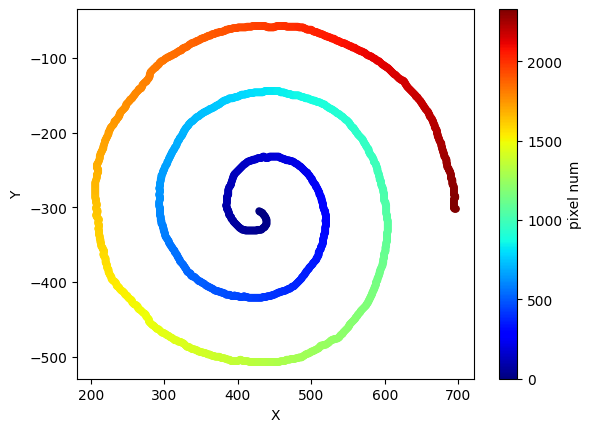

In [37]:
#trace_path
trace_path_time = np.array([[i[0], -i[1], j] for j, i in enumerate(trace_path)])

plt.scatter(trace_path_time[:,0], trace_path_time[:,1], c=trace_path_time[:,2], s=20, cmap='jet')
plt.colorbar(label='pixel num')
plt.xlabel('X')
plt.ylabel('Y')
